# Explorando o Iris Dataset
Baseado neste [artigo](https://www.kaggle.com/code/kostasmar/exploring-the-iris-data-set-scikit-learn)

## Preparando o ambiente
### Importanto bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

# %matplotlib inline

### Configurando o pandas para mostrar todas as colunas

In [2]:
pd.set_option('display.max_columns', None)

### Carregando o dataset que vem junto com o Scikit

In [3]:
iris_data = load_iris()

## Analisando a estrutura da base do Scikit
Monstrando como o dataset é organizado, mostrando os nomes dos campos

In [4]:
iris_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Mostrando as features

In [5]:
iris_data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Mostrando os alvos (tipos para classificação)

In [6]:
iris_data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## Montando o dataframe
Criando um _pandas dataframe_ com os dados da base e utilizando as _features_ como nome de coluna

In [7]:
iris_df = pd.DataFrame(data = iris_data['data'], columns = iris_data['feature_names'])
iris_df['Iris type'] = iris_data['target']

Tamano da base

In [8]:
iris_df.count()

sepal length (cm)    150
sepal width (cm)     150
petal length (cm)    150
petal width (cm)     150
Iris type            150
dtype: int64

Mostrar uma amostra da base

In [9]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Iris type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Preparando a base
Na base a coluna __Iris type__ (cópia da coluna __target__) indica o seguinte:

0 -> sentosa

1 -> versicolor

2 -> virginica

Acrescentar a coluna __Iris name__ traduzindo estes valores numéricos para texto, conforme a tabela acima

In [10]:
iris_df['Iris name'] = iris_df['Iris type'].apply(lambda x: 'sentosa' if x == 0 else ('versicolor' if x == 1 else 'virginica'))

Amostra da tabela resultante

In [11]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Iris type,Iris name
0,5.1,3.5,1.4,0.2,0,sentosa
1,4.9,3.0,1.4,0.2,0,sentosa
2,4.7,3.2,1.3,0.2,0,sentosa
3,4.6,3.1,1.5,0.2,0,sentosa
4,5.0,3.6,1.4,0.2,0,sentosa


## Visualizando os dados
### Gráfico de violino

Um gráfico de [violino](https://mode.com/blog/violin-plot-examples/#:~:text=What%20is%20a%20violin%20plot%3F,the%20density%20of%20each%20variable) é um híbrido entre o _box plot_ e _kernel density plot_ onde mostra a distribuição da amostra que mostra os picos nos dados.
É utilizado para visualizar a distribuição de dados numéricos.


In [12]:
# im just making a function in order not to repeat the same code
def plot_violin(y2,i):
    plt.subplot(2,2,i)
    
    sns.violinplot(x='Iris name',y= y2, data=iris_df)

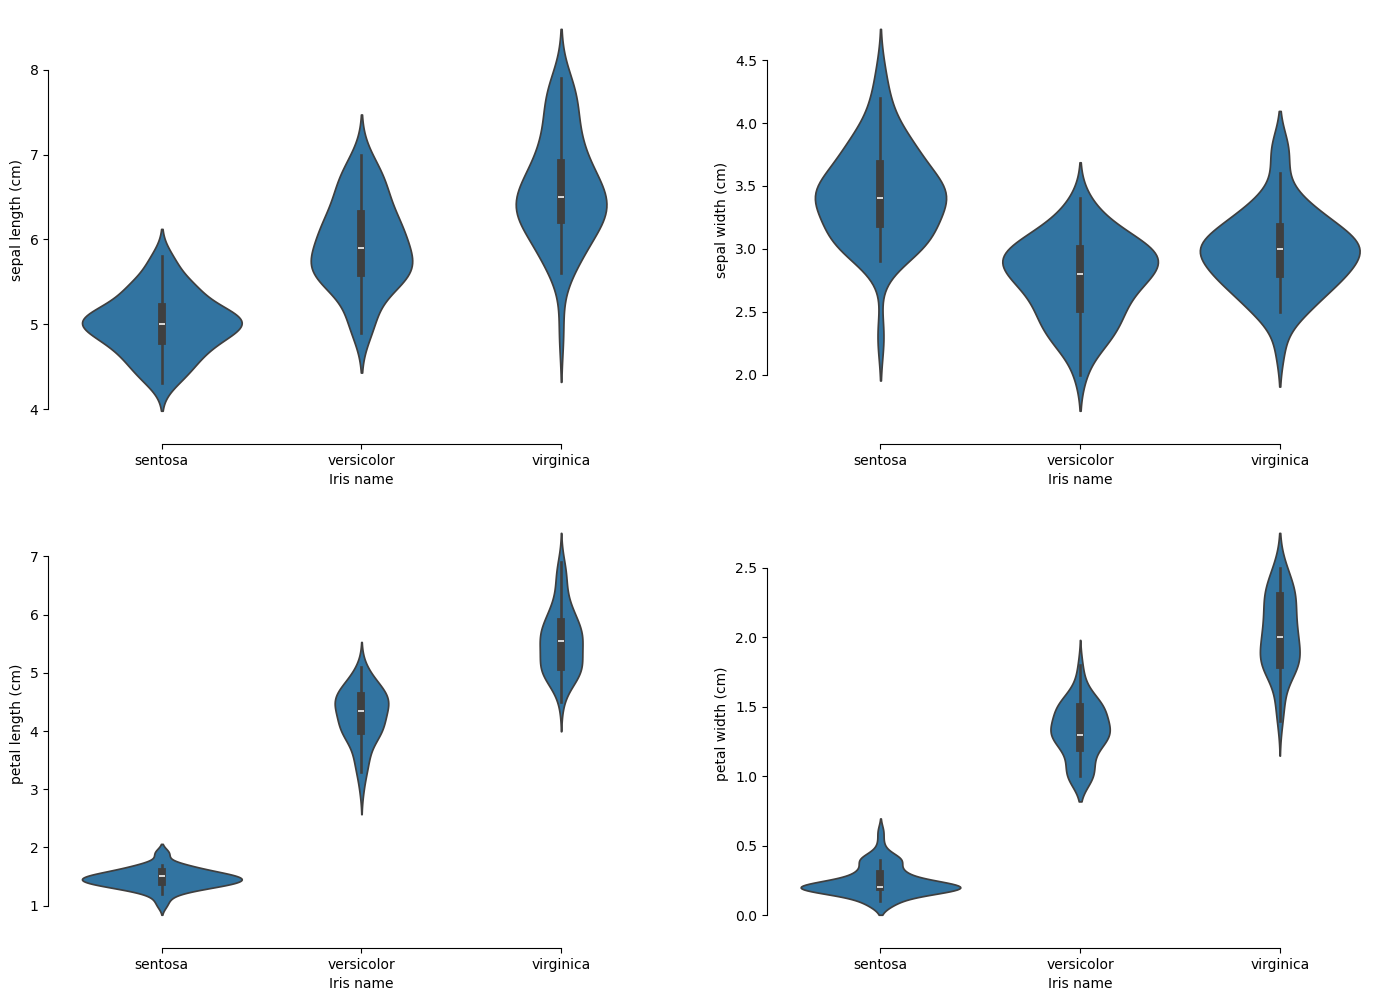

In [13]:
plt.figure(figsize=(17,12))
i = 1
for measurement in iris_df.columns[:-2]:
    plot_violin(measurement,i)
    sns.despine(offset=10, trim=True)
    i += 1

A partir dos gráficos de violino acima podemos notar uma alta densidade de comprimento e largura das espécies sentosa, especialmente para comprimento de sépala, comprimento de pétala e largura de pétala. Também podemos observar que os valores médios e o intervalo interquartil para as medidas das pétalas são facilmente distinguíveis, embora os valores das espécies virginica sejam mais dispersos

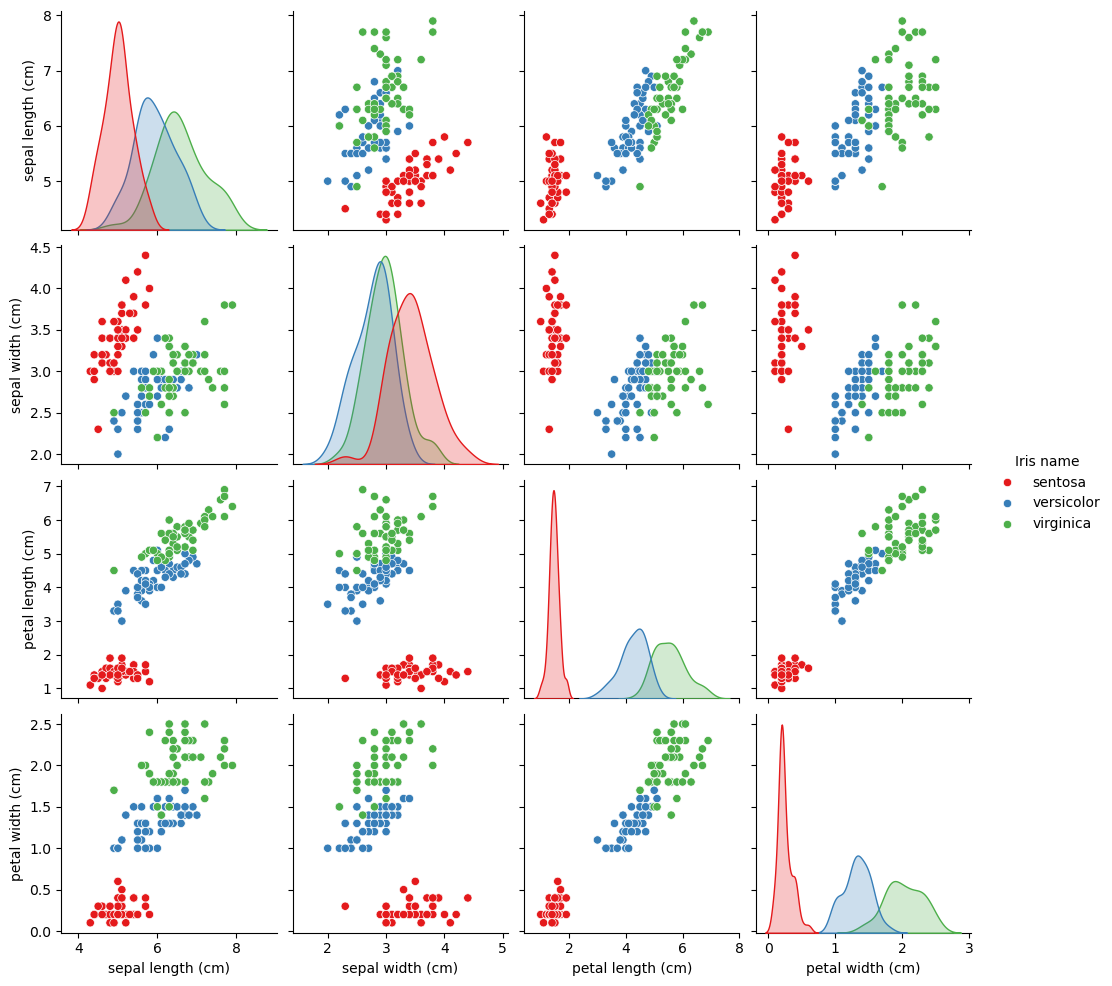

In [14]:
sns.pairplot(iris_df, hue = 'Iris name', vars = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], palette = 'Set1' );

A partir dos gráficos acima podemos notar que os três tipos diferentes podem ser facilmente identificados pelas medidas das pétalas e sépalas. Assim, um modelo de ML poderia aprender como separá-los.

Vamos também produzir um mapa de calor acima para descobrir as correlações entre as medições

In [15]:
iris_df.iloc[:,:4].corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


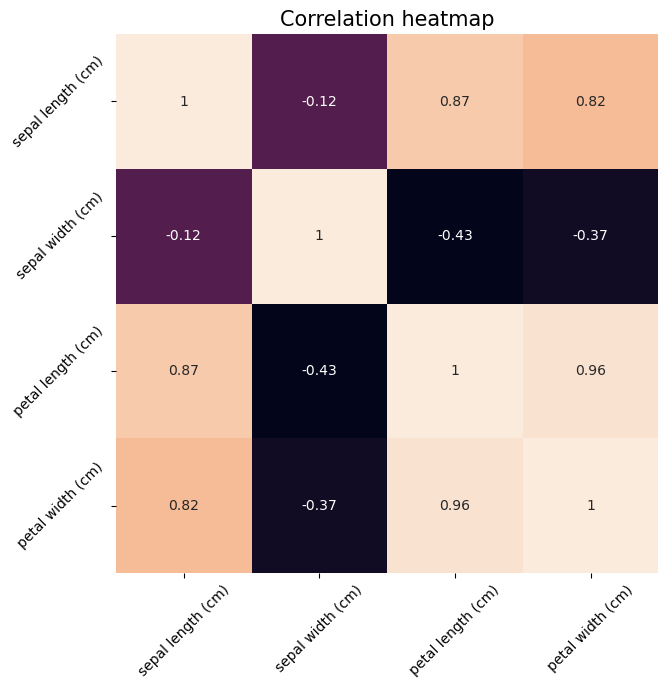

In [16]:
fig, axes = plt.subplots(figsize=(7,7))
sns.heatmap(iris_df.iloc[:,:4].corr(), annot = True, cbar=False)
axes.tick_params(labelrotation=45)
plt.title('Correlation heatmap', fontsize = 15);

A largura e a largura da sépala não estão correlacionadas, embora sejam altamente correlacionadas. Usar apenas medidas altamente correlacionadas pode aumentar nosso modelo de precisão.

## Treinando um modelo de Machine Learning

Vamos usar e testar o modelo k-Nearest Neighbors, e como nossos dados não parecem "ruidosos", podemos escolher um pequeno valor de k. Definiremos k como 3.

Embora tenhamos notado uma alta correlação entre as medidas de largura e comprimento das pétalas, utilizaremos todas as medidas disponíveis no momento, e posteriormente verificaremos qual dá a melhor precisão.

Além disso, tenha em mente que o KNN está calculando a distância euclidiana entre o ponto que queremos prever e o(s) ponto(s) de dados de treinamento mais próximo(s) (vizinho). Para este fim, dimensionar (normalizar) os dados antes de aplicar o alogirthm geralmente é uma boa abordagem. Porém, no nosso caso, todos os dados utilizam a mesma unidade de medida (cm), portanto isso não é necessário.

Vamos primeiro chamar train_test_split para dividir nossos dados

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']]
y = iris_df['Iris name']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [21]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## Avaliando o modelo

In [22]:
y_pred = knn.predict(X_test)

In [23]:
y_pred

array(['virginica', 'versicolor', 'sentosa', 'virginica', 'sentosa',
       'virginica', 'sentosa', 'versicolor', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'sentosa', 'versicolor', 'versicolor', 'sentosa',
       'sentosa', 'virginica', 'versicolor', 'sentosa', 'sentosa',
       'virginica', 'sentosa', 'sentosa', 'versicolor', 'versicolor',
       'sentosa', 'virginica', 'versicolor', 'sentosa', 'virginica',
       'virginica', 'versicolor', 'sentosa', 'virginica'], dtype=object)

Calculando a precisão com _knn.score()_

In [24]:
print(f'A precisão do modelo com k=3 é: {knn.score(X_test, y_test)*100:2.2f}% ({knn.score(X_test, y_test)})')

A precisão do modelo com k=3 é: 97.37% (0.9736842105263158)


## Gerando e visualizando a matriz de confusão

A Matriz de Confusão exibe a distribuição dos registros em termos de suas classes atuais e de suas classes previstas. Isso indica a qualidade do modelo atual. Um modelo pode conter duas ou mais classes previstas.

In [25]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
# also thanks https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics for his video, letting me know for this code
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.title('Confusion Matrix', fontsize = 16)
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    # return fig

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

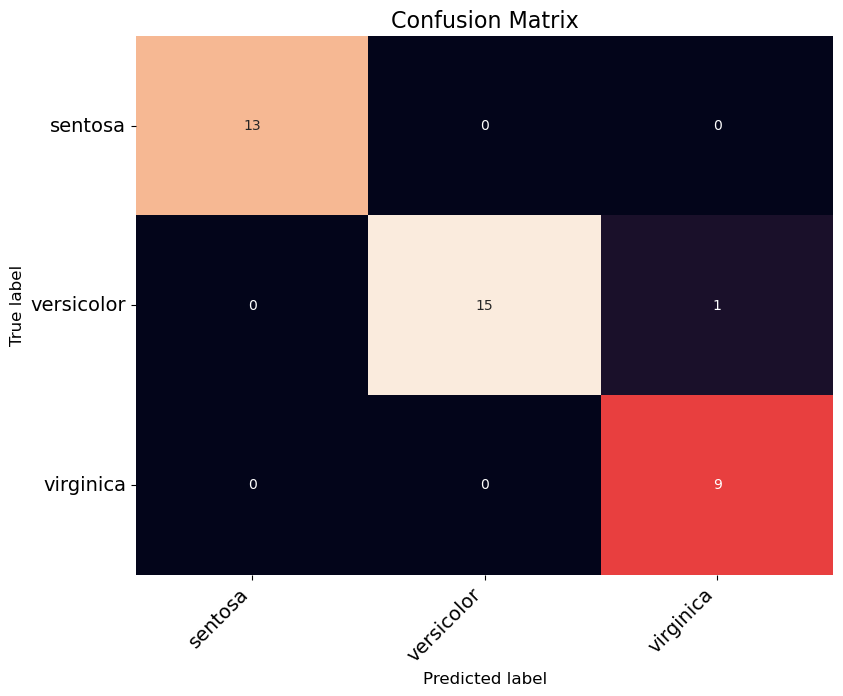

In [27]:
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['sentosa', 'versicolor', 'virginica'])

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     sentosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



De acordo com o relatório de classificação podemos notar exatidão, precisão e recall muito bons.

1. Precisão significa quantas previsões estavam corretas dentre o número da classe prevista. Precisão = TP/(TP + FP) Para sentosa e versicolor o KNN obteve precisão perfeita, enquanto para virginica 90%, o que significa que de todos os rótulos previstos atribuídos como virginica 90% estavam corretos. Mais precisamente, o modelo previu 10 flores como virginica, enquanto as 9 foram previsões corretas (TP) e 1 errada (FP). Precisão_virginica 9/(9+1) = 0,9.

2. Recall significa quantas previsões estavam corretas em relação ao número real da classe específica. Rechamada = TP/(TP + FN). Para versicolor, a pontuação de recall foi de 94%, o que significa que o modelo previu 15 flores versicolores (TP) corretas, enquanto 1 delas foi atribuída incorretamente como virginica (FN). Recall_versicolor = 15/(15 + 1) = 0,94.

Neste caso, como não temos grande desequilíbrio em nossa amostra, os escores de acurácia servem como uma boa medida de desempenho do modelo.

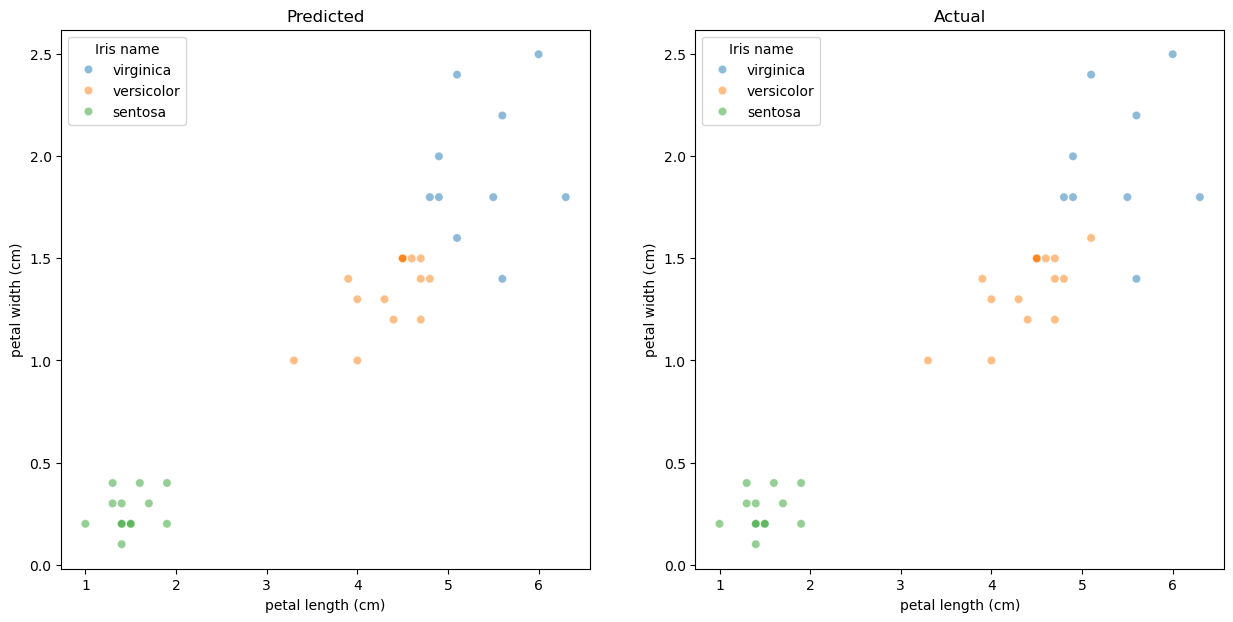

In [29]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(x = X_test['petal length (cm)'], y = X_test['petal width (cm)'], hue = y_pred, alpha = 0.5)
plt.title('Predicted')
plt.legend(title='Iris name')

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(x = X_test['petal length (cm)'], y = X_test['petal width (cm)'], hue = y_test, alpha = 0.5)
plt.title('Actual');